# Which Countries Love America the Most? Topic Extraction
In this project, we extract US favorability from the quotations provided in the QuoteBank dataset.
The steps are as follows:

LDA,
1. Sampling the new filtered data
2.


## 1. Sampling the new filtered data
In this part, we load the filtered data year by year and concatenate into a single dataframe.
Since we would like to apply an unsupervised learning on the dataset, we don't need anymore to drop the None-speakers
quotes, and we don't consider the nationalities in the topic detection training.

The problem is that the amount of data is huge and we cannot load them all to train the topic detection model.
The first solution is to load the data year by year and train the LDA model iteratively. The second solution which is
more advanced is to randomly sample the quotations. However, we sample the quotes proportionally to the num_occurrence
in the QuoteBank, i.e., the more frequently a quote shows, the more probable to be chosen. Then, we can cover the most
important quotes for the topic extraction.

In [1]:
import pandas as pd

def get_sample(ratio, df):
    occurrence_weight = df["numOccurrences"]/df["numOccurrences"].sum()
    sample_num = int(ratio * len(df))
    df_sampled = df.sample(n=sample_num, weights=occurrence_weight)
    return df_sampled

US_data = pd.DataFrame()
for year in range(2015, 2021) :
    year_df = pd.read_pickle('input/us_{}media.pkl.bz2'.format(year), compression='bz2')
    year_df = year_df.drop_duplicates(subset='quoteID', keep='first')
    # Remove the duplication in the dataset
    # Apply a random sampling proportional to the numOccurrences
    sampled_year_df = get_sample(ratio=0.1, df=year_df)
    US_data = pd.concat([US_data, sampled_year_df], axis=0)


US_data.sample(n=4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment
105499,2016-08-24-128810,We are closely watching the situation at the A...,None,[],2016-08-24 16:13:39,45,"[[None, 0.93], [Massoud Hossaini, 0.0422], [Ba...",http://rss.cnn.com/~r/rss/cnn_world/~3/ewUcyTR...,E,0.826913
20563,2019-01-21-070648,The proposal outlined by President Trump that ...,Mitch McConnell,[Q355522],2019-01-21 21:23:50,73,"[[Mitch McConnell, 0.4171], [None, 0.2868], [H...",https://www.seattletimes.com/nation-world/nati...,E,-0.523739
332147,2016-12-28-012178,determined to establish a constructive dialogu...,Antonio Guterres,[Q311440],2016-12-28 22:57:18,18,"[[Antonio Guterres, 0.8706], [None, 0.0916], [...",http://news.yahoo.com/un-chief-wants-meet-trum...,E,0.854434
169182,2017-11-02-098228,Our move would domicile our $20 billion annual...,None,[],2017-11-02 00:00:00,162,"[[None, 0.9066], [Rex Tillerson, 0.0934]]",http://foxbusiness.com/features/2017/11/02/whi...,E,-0.705446


As we can see in the data frame, the numbers of occurrence of the chosen samples are high.

## 2. Tokenization
As we learned in the ADA course, the first step to apply the text analysis is to tokenize the text into vectors and BoW.
Here, thanks to the nltk library, we first do the sentence tokenization to split the quotes into sentences. Then, the sentences should be split to
words and the stop words should be applied to the quotes. The stop words are the common stop words in English + the
keywords that we have used for the quoteBank filtering.


In [8]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from itertools import chain
nltk.download('stopwords')
nltk.download('punkt')
# Turn every quotes to a list of sentences
US_data["sentences"] = US_data.quotation.apply(lambda x: sent_tokenize(x))

# Turn sentences to words
US_data["token_sentences"] = US_data.sentences.apply(lambda  x: [word_tokenize(sentence) for sentence in x])

# Create the stopwords
US_keywords = ["us", "u.s", "usa", "united", "states", "american", "americans"]
speaker_keywords = ["trump", "york", "washington", "biden", "obama", "warren",
            "sanders", "hollywood", "harris", "cohen", "apple", "nixon",
            "clinton", "williams", "bush", "lincoln", "kennedy", "pompeo",
            "donald", "ocasio", "pence", "tesla", "don", "nelson",
            "tarantino", "baldwin", "bannon", "bolton", "barr"]
my_stopwords = stopwords.words('english') + US_keywords + speaker_keywords

# Apply the stopwords and lower case the tokens
US_data["tokens"] = US_data.token_sentences.apply(lambda sentences: list(chain.from_iterable(sentences)))
US_data["tokens"] = US_data.tokens.apply(lambda tokens: [token.lower() for token in tokens if token.isalpha()
                                                    and token.lower() not in my_stopwords and len(token)>1] )
US_data.sample(n=6)

[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment,sentences
45332,2015-10-23-068057,"Like in American movies, we sat in a circle; a...",None,[],2015-10-23 21:21:25,3,"[[None, 0.9084], [Aydın Doğan, 0.0916]]",http://hurriyetdailynews.com/stories-of-ankara...,E,0.469517,"[Like in American movies, we sat in a circle; ..."
179346,2018-02-16-019864,Critics who favor eliminating U.S. nuclear sys...,James N. Mattis,[Q267902],2018-02-16 00:00:00,3,"[[James N. Mattis, 0.9128], [None, 0.0873]]",https://www.defense.gov/News/Article/Article/1...,E,0.958738,[Critics who favor eliminating U.S. nuclear sy...
473905,2018-04-09-037388,I have been advised by federal prosecutors tha...,Stephen Ryan,[Q7610427],2018-04-09 00:00:00,356,"[[Stephen Ryan, 0.5989], [None, 0.2987], [Mich...",http://abcnews.go.com/Politics/fbi-raids-offic...,E,0.386872,[I have been advised by federal prosecutors th...
155922,2019-12-30-067248,Will we continue with our association with the...,None,[],2019-12-30 21:44:36,1,"[[None, 0.8285], [Don Fabian, 0.1715]]",https://www.dvidshub.net/news/357676/psycholog...,E,0.945945,[Will we continue with our association with th...


## 3. Train an LDA model
Here we go! We have the tokens for every rows and need to train an LDA model with them. First we initialize a dictionary
and corpus based on the tokens we obtained. Then, we will find $n$ topics for our dataset. But wait! What is $n$?

In [ ]:
from gensim import corpora
tokens = US_data.tokens.tolist()
# get the dictionary for the tokens
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]


To choose the best value for $n$ we perform the training for several values of $n$ on a smaller dataset. Then, we decide
the optimal number of $n$ based on the **Coherence Score**.  This scores shows how much the tokens are correalted with
the topics we extract.

In [ ]:
from gensim import models
# We choose the number of topics in logarithmic steps
for num_topics in [25, 50, 75, 100, 150, 200, 500]:
    lda_model = models.LdaModel(corpus, num_topics=num_topics,
                                id2word=dictionary_LDA,
                                alpha='auto',
                                eta='auto',
                                passes=4)
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Num Topics: {}, Coherence Score: {}'.format(num_topics, coherence_lda))


We choose a number of topic that marks the end of a rapid growth of calculated topic coherence. Thus, we chose 150
number of topics to have meaningful and interpretable topics. For the number of topic >= 200, we got lots of keywords
repeated in several topics.

In [ ]:
from gensim import models
optimal_num_topics  = 150
optimal_model = models.LdaModel(corpus, num_topics=optimal_num_topics,
                                id2word=dictionary_LDA,
                                alpha='auto',
                                eta='auto',
                                passes=4)


In [ ]:
optimal_model.save("output/topic/topic_model_150")
dictionary_LDA.save("output/topic/dictionary_150")
corpora.MmCorpus.serialize("output/topic/corpus", corpus)

In [ ]:
coherence_model_lda = models.CoherenceModel(model=optimal_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: {}'.format(coherence_lda))


In [ ]:
for i,topic in optimal_model.show_topics(formatted=True, num_topics=150):
    print(str(i)+": "+ topic)
    print()

In [ ]:
# US_with_nation = US_with_nation.drop(columns=['quotation', 'qids', 'urls', 'sentences', 'token_sentences'])

In [ ]:
!pip install pyLDAvis

In [ ]:
num_topics = 150
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(topic_model=optimal_model, corpus=corpus, dictionary=dictionary_LDA, mds='mmds')
pyLDAvis.save_html(LDAvis_prepared, 'output/ldavis_prepared_'+ str(num_topics) +'total.html')
LDAvis_prepared


In [ ]:
topic_table = LDAvis_prepared.token_table
topic_table[topic_table["Term"] == "iran"]

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig = plt.figure(figsize=(18,6))
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(WordCloud(background_color="white").fit_words(dict(optimal_model.show_topic(i, 200))),
               interpolation='bilinear')
    plt.axis("off")
plt.tight_layout()
plt.savefig('output/wordcloud.png')


## 3. Add nationality to the main df
In this part, we use the speaker attributes dataset provided on the project web page. We need only id and nationality of
 the speakers; therefore, we keep these two columns. Then, we map the speaker id in Quotebank to this library.

In [2]:
import pandas as pd
speaker_df = pd.read_parquet("input/speaker_attributes.parquet")
speaker_df = speaker_df[['id', 'nationality']]
speaker_df.sample(n=5)

,id,nationality
8111678,Q6849662,None
3665838,Q12729189,[Q218]
2959340,Q75330322,None
5485100,Q95703654,None
4127394,Q75886378,None


In [3]:
US_data["speaker_id"] = US_data.qids.map(lambda x: x[0])

#join US_data with the corresponding speakers' attributes
US_merged = pd.merge(US_data, speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
# Some speakers has no nationality. Let's drop them.
US_merged = US_merged[US_merged.nationality.notna()]
US_merged.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment,speaker_id,id,nationality
760295,2015-03-30-049209,"Not to be overly patriotic, but we're an Ameri...",Bo Ryan,[Q4931159],2015-03-30 16:06:00,89,"[[Bo Ryan, 0.9338], [None, 0.0523], [Chris Duf...",http://news-sentinel.com/apps/pbcs.dll/article...,E,0.820692,Q4931159,Q4931159,[Q30]
59011,2015-06-16-046847,So ladies and gentlemen... I am officially run...,Donald Trump,"[Q22686, Q27947481]",2015-06-16 07:17:42,330,"[[Donald Trump, 0.6451], [None, 0.3249], [Ivan...",http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/H...,E,0.972350,Q22686,Q22686,[Q30]
1088153,2015-02-14-019375,If you're going to have Jordan supporting the ...,Anthony Cordesman,[Q4772307],2015-02-14 08:47:20,3,"[[Anthony Cordesman, 0.628], [None, 0.372]]",http://www.worldbulletin.net/haberler/154998/u...,E,0.554413,Q4772307,Q4772307,[Q30]
244082,2015-07-14-017360,But it soon became clear that the NRSC had eve...,Ted Cruz,[Q2036942],2015-07-14 09:15:20,8,"[[Ted Cruz, 0.5186], [None, 0.2783], [Josh Hol...",http://www.politico.com/story/2015/07/ted-cruz...,E,-0.773929,Q2036942,Q2036942,"[Q30, Q16]"
9165,2015-10-13-088639,the American people are sick and tired of hear...,Bernie Sanders,[Q359442],2015-10-13 10:14:00,1842,"[[Bernie Sanders, 0.63], [None, 0.2155], [Hill...",http://patriotpost.us/opinion/38289,E,-0.968833,Q359442,Q359442,[Q30]


Now, we have the speaker's nationality. However the nationality is coded as Q_i where i is an integer.
To translate this id to the name of the country we use *Wikidata API* to create a dictionary of country ids and names.



In [4]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#sparkql query to get the country name and their respective quids from wikidata
query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""

'''
query internet dataset:
endpoint_url (string): url of corresponding dataset
query (string): sparksql query
'''
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

#Build a country dictionnary {quid, country name}
country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']
country_dict

{'Q889': 'Afghanistan',
 'Q222': 'Albania',
 'Q262': 'Algeria',
 'Q228': 'Andorra',
 'Q916': 'Angola',
 'Q781': 'Antigua and Barbuda',
 'Q414': 'Argentina',
 'Q399': 'Armenia',
 'Q408': 'Australia',
 'Q40': 'Austria',
 'Q227': 'Azerbaijan',
 'Q398': 'Bahrain',
 'Q902': 'Bangladesh',
 'Q244': 'Barbados',
 'Q184': 'Belarus',
 'Q31': 'Belgium',
 'Q242': 'Belize',
 'Q962': 'Benin',
 'Q917': 'Bhutan',
 'Q750': 'Bolivia',
 'Q225': 'Bosnia and Herzegovina',
 'Q963': 'Botswana',
 'Q155': 'Brazil',
 'Q921': 'Brunei',
 'Q219': 'Bulgaria',
 'Q965': 'Burkina Faso',
 'Q967': 'Burundi',
 'Q424': 'Cambodia',
 'Q1009': 'Cameroon',
 'Q16': 'Canada',
 'Q1011': 'Cape Verde',
 'Q929': 'Central African Republic',
 'Q657': 'Chad',
 'Q298': 'Chile',
 'Q739': 'Colombia',
 'Q970': 'Comoros',
 'Q800': 'Costa Rica',
 'Q224': 'Croatia',
 'Q204920': 'Crown of Aragon',
 'Q241': 'Cuba',
 'Q229': 'Cyprus',
 'Q213': 'Czech Republic',
 'Q1008': "Côte d'Ivoire",
 'Q756617': 'Danish Realm',
 'Q974': 'Democratic Republic 

In [5]:
# Add nationality of speaker from the country dictionary
US_with_nation = US_merged.explode('nationality')
US_with_nation.nationality = US_with_nation.nationality.map(country_dict)
US_with_nation.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment,speaker_id,id,nationality
60274,2015-12-11-121328,to control our U.S. politicians with daddy's m...,Donald Trump,"[Q22686, Q27947481]",2015-12-11 06:24:25,31,"[[Donald Trump, 0.7471], [None, 0.2344], [Evan...",http://www.wibw.com/home/headlines/Trump-calls...,E,-0.058808,Q22686,Q22686,United States of America
1216176,2015-08-30-069486,When we were working on the plot it just seeme...,Alex Kendrick,[Q621514],2015-08-30 14:32:46,6,"[[Alex Kendrick, 0.8106], [None, 0.1894]]",http://bangordailynews.com/2015/08/31/living/h...,E,-0.393621,Q621514,Q621514,United States of America
75183,2015-07-15-035275,I am concerned by the potential national secur...,John McCain,[Q10390],2015-07-15 20:42:03,16,"[[John McCain, 0.7143], [None, 0.2857]]",http://us.rd.yahoo.com/finance/news/rss/story/...,E,-0.552284,Q10390,Q10390,United States of America
786650,2015-04-21-058943,There have been problems with systematic and p...,Phil Robertson,[Q14755515],2015-04-21 17:03:13,31,"[[Phil Robertson, 0.9335], [None, 0.0665]]",http://www.sfgate.com/news/crime/article/US-le...,E,0.867352,Q14755515,Q14755515,United States of America
540379,2015-03-03-078689,The relationship between the United States and...,Susan Rice,"[Q23848423, Q50612]",2015-03-03 10:44:00,6,"[[Susan Rice, 0.8889], [None, 0.0918], [Benjam...",http://live5news.com/story/28245721/white-hous...,E,-0.960320,Q23848423,Q23848423,United Kingdom


## 4. Get Sentiments
In this part, we get the sentiment of the quotes. We use a pre-trained library to extract the sentiment.
Any other libraries can be replaced here. In this milestone we used *nltk* because it is faster than other famous libraries.
For the next milestone, the library may be changed.

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
sia = SentimentIntensityAnalyzer()
# predict the sentiment of each quotation in the range [-1, 1]
US_with_nation["sentiment"] = US_with_nation.quotation.apply(lambda x: sia.polarity_scores(x)["compound"])
US_with_nation.sample(n=5)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_id,id,nationality,sentiment
55920,2017-04-05-080851,It's not right to connect with racism before p...,Sushma Swaraj,[Q1652493],2017-04-05 07:26:58,1,"[[Sushma Swaraj, 0.8364], [None, 0.1636]]",[http://www.india.com/news/india/sushma-swaraj...,E,Q1652493,Q1652493,India,-0.7906
91058,2015-04-10-079857,They (the U.S. and her allies) shouldn't be al...,Ali Khamenei,[Q57336],2015-04-10 03:58:40,1,"[[Ali Khamenei, 0.8768], [None, 0.0933], [Bara...",[http://www.commdiginews.com/politics-2/tower-...,E,Q57336,Q57336,Iran,0.3182
197907,2019-04-12-119611,What is needed is for the U.S. to stop its cur...,Kim Jong Un,"[Q14045951, Q56226]",2019-04-12 22:13:50,21,"[[Kim Jong Un, 0.3924], [None, 0.3891], [Kim J...",[http://www.straitstimes.com/asia/east-asia/no...,E,Q14045951,Q14045951,Spain,-0.2960
465560,2015-12-27-037085,the control system in this form is already est...,Alexander Dobrindt,[Q85783],2015-12-27 00:00:00,51,"[[Alexander Dobrindt, 0.8602], [None, 0.1331],...",[http://abcnews.go.com/International/wireStory...,E,Q85783,Q85783,Germany,0.0000
158567,2015-01-14-012753,Cruz hopes to attach an amendment lifting the ...,Ted Cruz,[Q2036942],2015-01-14 13:21:58,2,"[[Ted Cruz, 0.7196], [None, 0.2804]]",[http://feeds.washingtonpost.com/c/34656/f/669...,E,Q2036942,Q2036942,United States of America,-0.6771


## 5. Billion-Dollar Question: How much people love US?
In this part, we show the US favorability using the quotes. The sentiment average and the number of quotes for each country
is represented in the following figures.

<AxesSubplot:title={'center':'Number of quotes'}, ylabel='nationality'>

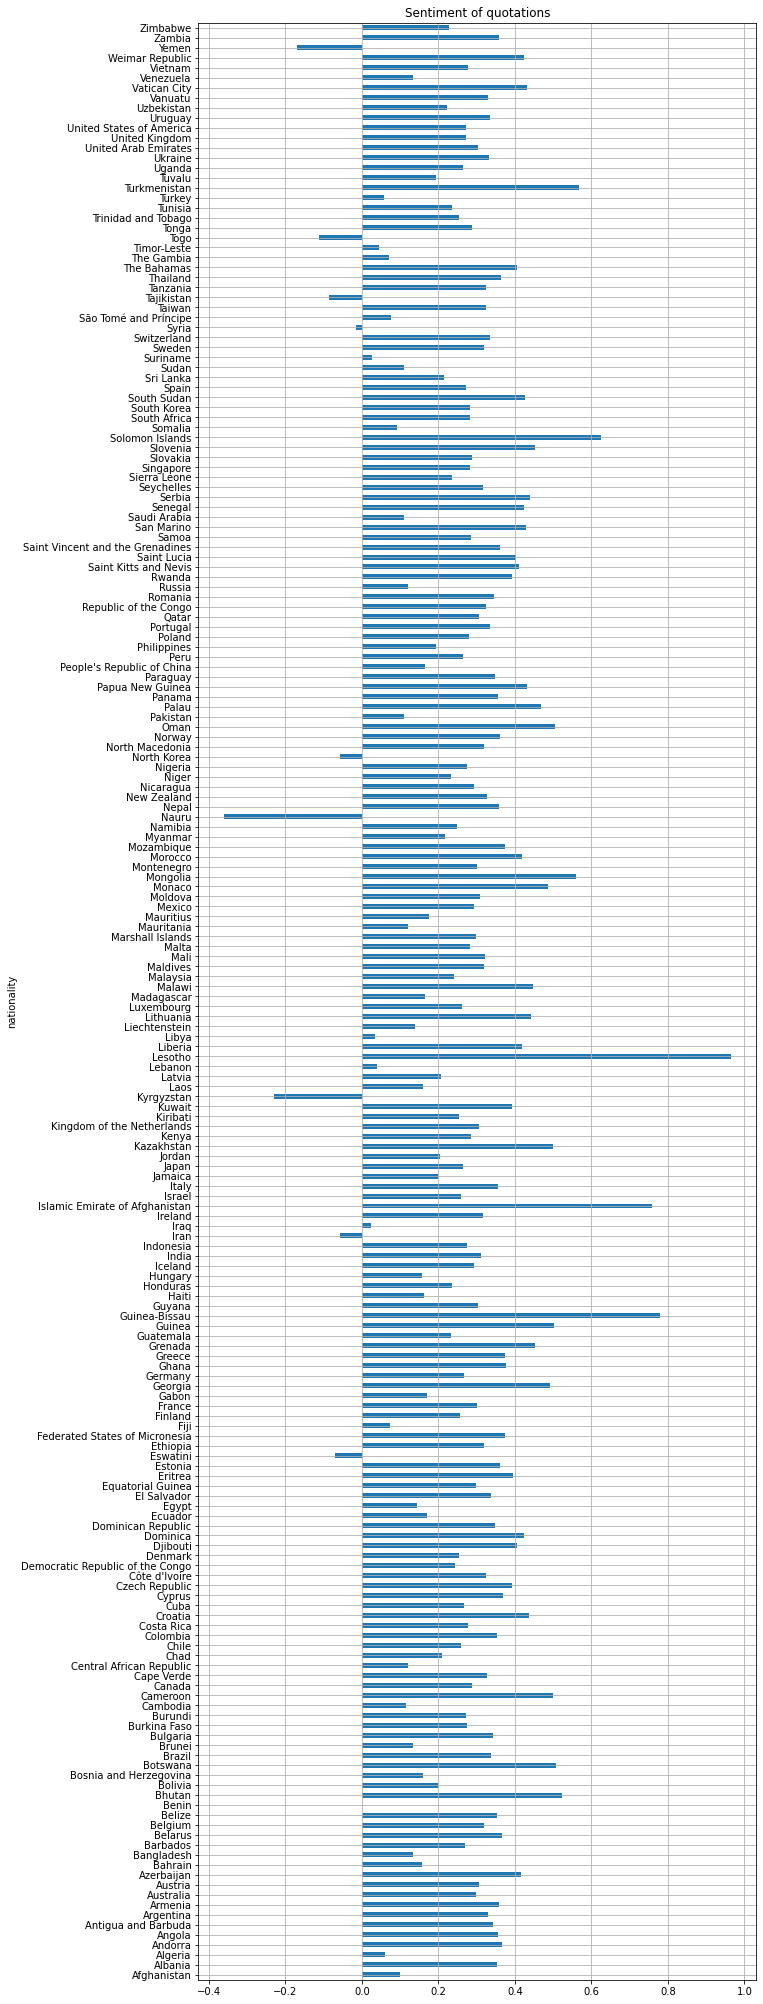

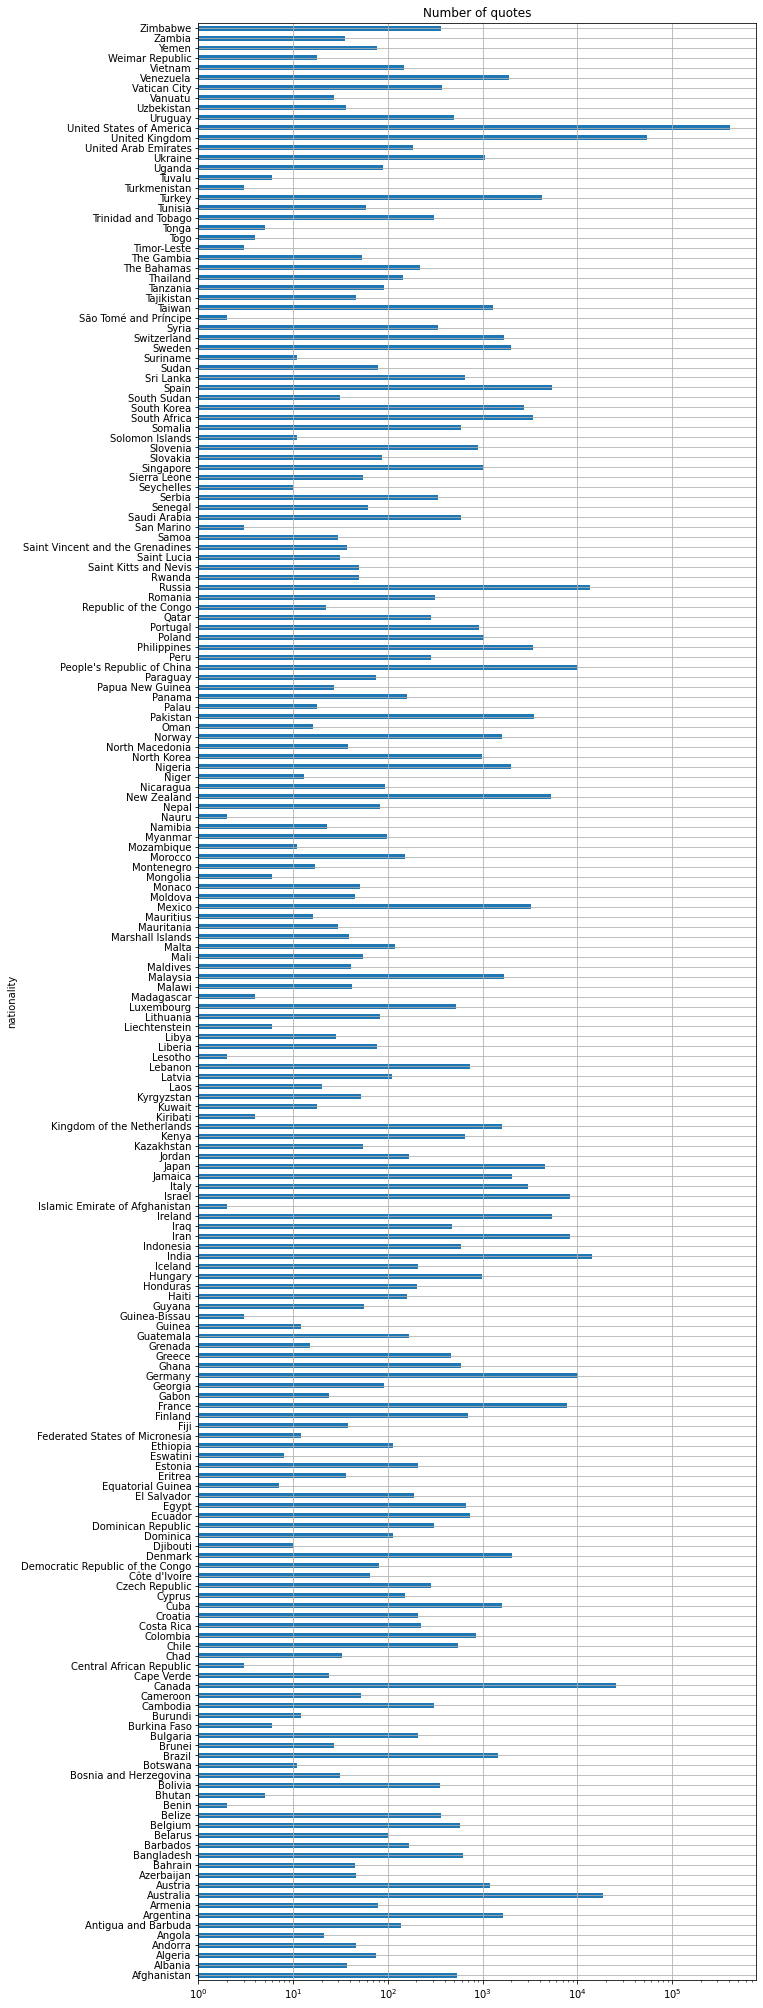

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 36))
plt.title("Sentiment of quotations")
#average sentiment for each country
US_love_mean = US_with_nation.groupby("nationality")["sentiment"].mean()
US_love_mean.plot.barh(grid=True)

plt.figure(figsize=(10,36))
plt.title("Number of quotes")
#count the number of quotes for each country
US_with_nation.groupby("nationality")["sentiment"].count().plot.barh(grid=True, log=True, align='center')


To make a brief analysis, in overall, most the countries seem at first sight more favorable to the USA.. Unsuprisingly the distribution of the number of quotes per country is highly non-uniform.

#### Map creation
In this part we show the countries on the map. Since the name of some countries are different in the map library we
need to assign new names in our table.

In [40]:
country_name_map = {
    "People's Republic of China": "China",
    "Kingdom of the Netherlands": "Netherlands",
    "Republic of the Congo": "Congo",
    "South Sudan": "S. Sudan",
    "Democratic Republic of the Congo": "Dem. Rep. Congo",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "Czech Republic": "Czechia",
    "North Macedonia": "Macedonia",
    "The Bahamas": "Bahamas",
    "Dominican Republic": "Dominican Rep.",
    "Solomon Islands": "Solomon Is.",
    "Central African Republic": "Central African Rep."}

US_with_new_nation = US_with_nation.replace(country_name_map)
US_love_mean = US_with_new_nation.groupby("nationality")["sentiment"].mean()

In [42]:

import geopandas
#load world map dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#connect US_data with map dataframe
table = world.merge(US_love_mean, how="left", left_on=['name'], right_on=['nationality'])


# Clean data: remove rows with no data
table = table.dropna(subset=['sentiment'])

In [45]:
import folium

#create Map object to do the plot
my_map = folium.Map()

# Map parameters with as color foreach country its sentiment average
folium.Choropleth(
    geo_data=table,
    name='choropleth',
    data=table,
    columns=['name', 'sentiment'],
    key_on='feature.properties.name',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sentiment of Quotes',
    missing_kwds={'color': 'white'}
).add_to(my_map)

#Save Map figure
my_map.save('us_love.html')

## 6. Load PEW Research Center Dataset

In this section, the datasets provided by PEW research center are loaded and processed.
We extract the nationality, sex, age of the participants and also their answer to the question: "How much you like the
United States?"

In [11]:
!pip install pyreadstat

column_names = ['country', 'fav_us', 'sex', 'age']

#columns labels foreach year (have changed over time)
#"fav_US" denoting their negative or positive view (i.e. their "sentiments") towards the U.S.A.
columns = {2015: ['COUNTRY', 'Q12A', 'Q145', 'Q146'],
           2016: ['country', 'Q10A', 'q107', 'q108'],
           2017: ['Country', 'fav_US', 'sex', 'age'],
           2018: ['COUNTRY', 'fav_US', 'sex', 'age'],
           2019: ['country', 'FAV_US', 'SEX', 'AGE'],
           2020: ['country', 'fav_US', 'sex', 'age']}

pew = pd.DataFrame()

for year in range(2015, 2021):
    #create dataframe from PEW dataset
    pew_year = pd.read_spss("input/pew/{}.sav".format(year))
    pew_year_fav = pew_year[columns[year]]
    pew_year_fav.columns = column_names
    pew_year_fav['year'] = year
    #concat each year to one dataframe
    pew = pd.concat([pew, pew_year_fav], axis=0, ignore_index=True)

#Save the pew dataframe
pew.to_csv('input/pew.csv', index=False)


In [46]:
import pandas as pd
import numpy as np

pew = pd.read_csv('input/pew.csv')

#List of "invalid" answers in pew dataset
Nan_keywords = ['Refused', 'Don’t know', 'Don’t know (DO NOT READ)', 'Refused (DO NOT READ)',
       '(VOL) Refused', "(VOL)\xa0Don't know"]

pew = pew.replace(to_replace=Nan_keywords, value=np.NaN)

#map "sentiment" to float values
fav_dict = {'Somewhat favorable': 0.5, 'Very favorable':1,
       'Somewhat unfavorable':-0.5, 'Very unfavorable':-1}

pew = pew.replace(fav_dict)


pew.sample(n=5)


,country,fav_us,sex,age,year
50673,Spain,-0.5,Female,29.0,2016
158437,Japan,-0.5,Male,75.0,2019
144738,Bulgaria,-0.5,Female,34.0,2019
42296,Burkina Faso,1.0,Female,60.0,2015
25221,Venezuela,1.0,Female,33.0,2015


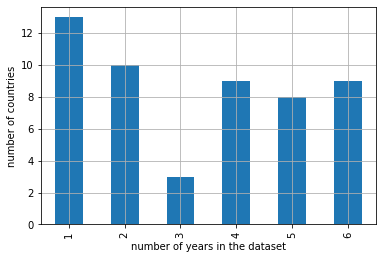

In [13]:
# foreach country, count the number of years it has appeared in the PEW yearly report
# then count the number of country who has appeared 1, 2, 3 times, etc...
pew.groupby('country')['year'].nunique().value_counts().sort_index(ascending=True).plot(kind='bar')
plt.xlabel('number of years in the dataset')
plt.ylabel('number of countries')
plt.grid()



Unique Countries: 52


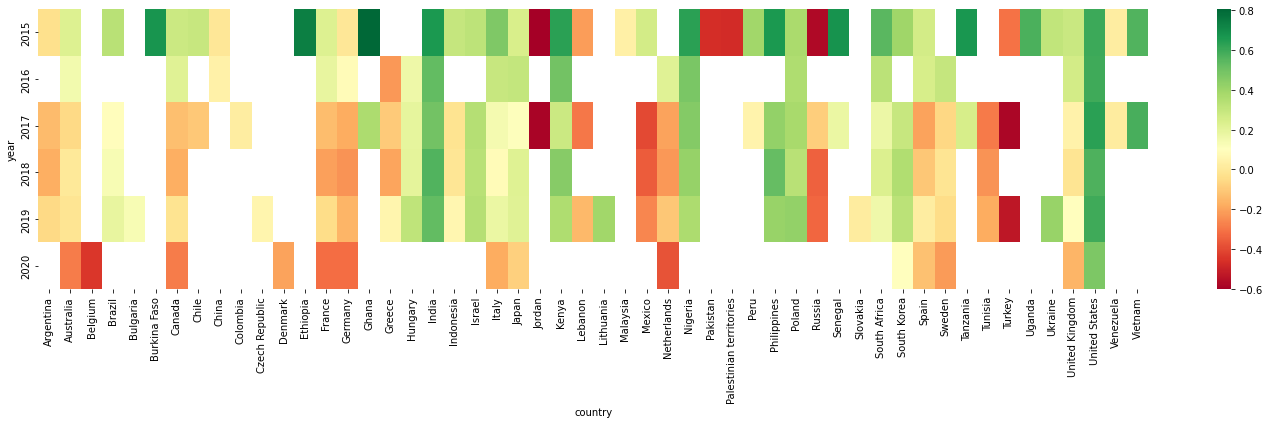

In [47]:
# heatmap for countries and years
import seaborn as sns
import matplotlib.pyplot as plt

pew_fav_us = pew.groupby(['country', 'year'], as_index=False)['fav_us'].mean()
pew_fav_pivot = pew_fav_us.pivot(index='year', columns='country', values='fav_us')
# pew_fav_pivot
plt.figure(figsize=(20,6))
sns.heatmap(pew_fav_pivot, cmap ='RdYlGn')
plt.tight_layout()
plt.savefig("output/pew_heatmap.jpg")
print("Unique Countries: {}".format(pew_fav_us.country.nunique()))

As we can see, there is few countries that have been analysed over all the years (only 9), and in total only around 50 countries appears in their reports.

### 7. Compare the datasets of PEW and QuoteSentiment

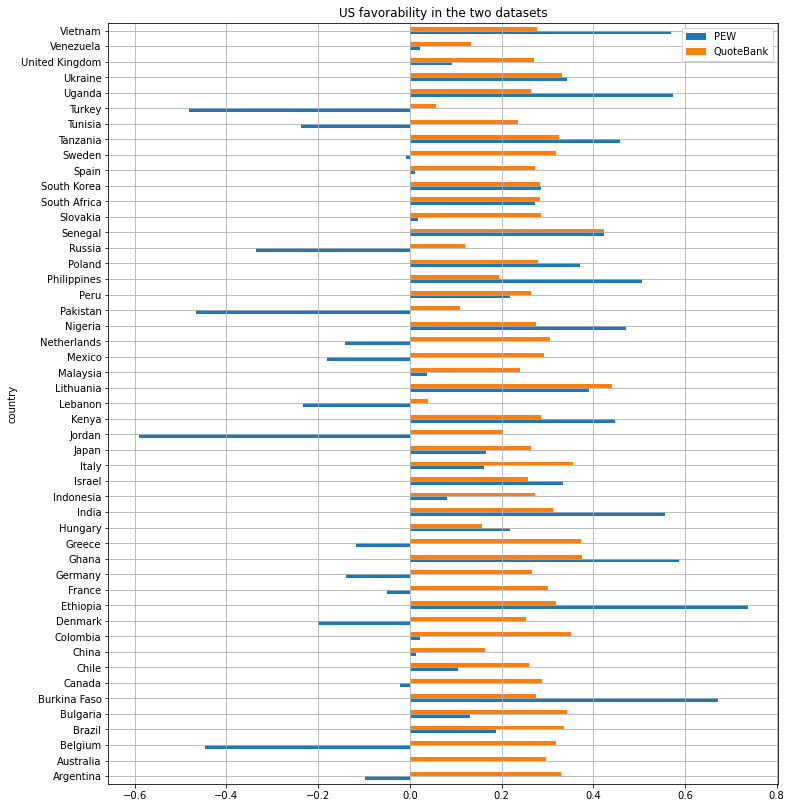

In [53]:
#Compute the mean sentiment for each country from the pew dataset report
pew_fav_us = pew.groupby('country')['fav_us'].mean().reset_index(name='PEW')
quote_fav_us = US_love_mean.reset_index(name='QuoteBank')
# merge the results of our sentiment analysis and the results of the pew dataset to create the plot
pew_quote_df = pd.merge(left=pew_fav_us, right=quote_fav_us, left_on='country', right_on='nationality')

pew_quote_df.plot(x= 'country', figsize=(12,14), kind='barh')
plt.title("US favorability in the two datasets")
plt.grid()
plt.savefig("output/compare_pew.png")

It appears that there is a large difference between the quotations sentiment analysis we have made and the one made in the pew study. We should not forget that this first analysis was made over a small dataset containing just one year.

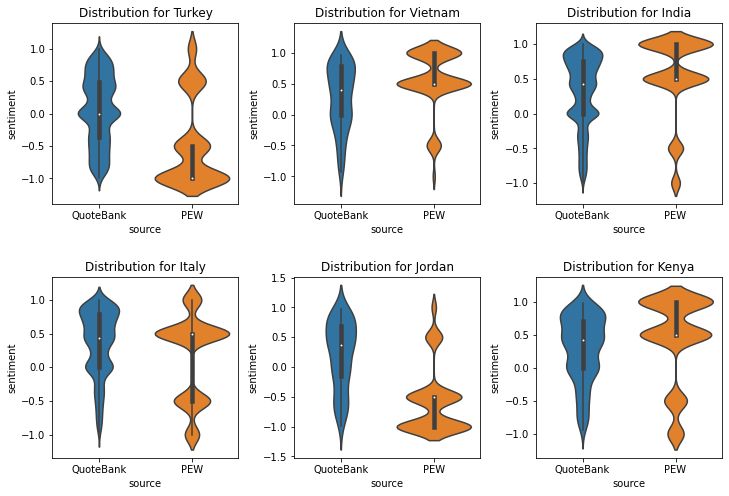

In [59]:
import seaborn as sns
US_with_nation["source"] = "QuoteBank"
pew["source"] = "PEW"
pew = pew.rename(columns={'fav_us': 'sentiment'})
fig = plt.figure(figsize=(12,8))
for idx, country_name in enumerate(["Turkey", "Vietnam", "India", "Italy", "Jordan", "Kenya"]):
    country_sentiment = US_with_nation[US_with_nation.nationality==country_name][["sentiment", "source"]]
    country_pew = pew[(pew.country==country_name)][["sentiment", "source"]]
    plt.subplot(2,3,idx+1)
    plt.title("Distribution for {}".format(country_name))
    sns.violinplot(x="source", y="sentiment", data=pd.concat([country_sentiment, country_pew]))

plt.subplots_adjust(wspace=0.3, hspace=0.4)


In [13]:
US_with_nation["year"] = US_with_nation.date.dt.strftime('%Y')

In [22]:
country_list = ['Argentina', 'Australia', 'Brazil', 'Canada', 'France', 'Germany', 'Greece', 'Hungary', 'India',
                'Indonesia', 'Israel', 'Italy', 'Japan', 'Kenya', 'Lebanon', 'Mexico', 'Kingdom of the Netherlands', 'Nigeria',
                'Philippines', 'Poland', 'Russia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Turkey',
                'Ukraine', 'United Kingdom', 'United States of America']
from scipy import stats

for country in country_list:
    obama_cond = (US_with_nation["nationality"] == country) & ((US_with_nation["year"] == '2015') | (US_with_nation["year"] == '2016'))
    trump_cond = (US_with_nation["nationality"] == country) & ((US_with_nation["year"] == '2019') | (US_with_nation["year"] == '2020'))
    obama_sentiment = US_with_nation[obama_cond]["sentiment"]
    trump_sentiment = US_with_nation[trump_cond]["sentiment"]
    _, p_value = stats.ttest_ind(obama_sentiment,trump_sentiment,alternative='two-sided')
    print("Country : {},\tObama: {:.2f}\tTrump: {:.2f}".format(country, obama_sentiment.mean(), trump_sentiment.mean()))
    print("P value: {}\n".format(p_value))


Country : Argentina,	Obama: 0.40	Trump: 0.21
P value: 3.98398643332095e-08

Country : Australia,	Obama: 0.32	Trump: 0.27
P value: 2.7812998962077115e-07

Country : Brazil,	Obama: 0.35	Trump: 0.30
P value: 0.15326618657856966

Country : Canada,	Obama: 0.30	Trump: 0.29
P value: 0.08707762790082633

Country : France,	Obama: 0.34	Trump: 0.26
P value: 2.001647058675278e-06

Country : Germany,	Obama: 0.30	Trump: 0.25
P value: 0.0008167181680847943

Country : Greece,	Obama: 0.33	Trump: 0.38
P value: 0.41158051280954233

Country : Hungary,	Obama: 0.08	Trump: 0.16
P value: 0.1250054055836782

Country : India,	Obama: 0.34	Trump: 0.32
P value: 0.04790780138481843

Country : Indonesia,	Obama: 0.24	Trump: 0.27
P value: 0.6229069924148012

Country : Israel,	Obama: 0.25	Trump: 0.27
P value: 0.42841859649629754

Country : Italy,	Obama: 0.37	Trump: 0.29
P value: 0.0026162689584306106

Country : Japan,	Obama: 0.28	Trump: 0.26
P value: 0.31117024320659503

Country : Kenya,	Obama: 0.32	Trump: 0.25
P value

In [5]:
print("Total: {}\nPositive: {}\nNegative: {}".format(
    len(US_with_nation),
    len(US_with_nation[US_with_nation.sentiment > 0]),
    len(US_with_nation[US_with_nation.sentiment <= 0])
))

Total: 193779
Positive: 102367
Negative: 91412


## Topic detection group by countries


In [10]:
from gensim import models
temp_file = "output/topic/topic_model_150"
pretrained_lda = models.LdaModel.load(temp_file)

In [59]:
from gensim import corpora
lda_dict = corpora.Dictionary.load("output/topic/dictionary_150")
lda_corp = corpora.MmCorpus("output/topic/corpus")

In [74]:
def get_dominant_topic(tok):
    topics_prob = pretrained_lda[lda_dict.doc2bow(tok)]
    topics_sorted = sorted(topics_prob, key=lambda x: (x[1]), reverse=True)
    dominant_num, dominant_prop = topics_sorted[0]
    return dominant_num

In [20]:
len(US_with_nation)

1394695

In [75]:
# get_dominant_topic(US_with_nation['tokens'].loc[10])
US_with_nation['topic'] = US_with_nation.tokens.apply(lambda x: get_dominant_topic(x))


In [76]:
US_with_nation.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,phase,sentiment,speaker_id,id,nationality,sentences,token_sentences,tokens,topic
918780,2015-11-11-102214,the United States and our international partne...,Steny Hoyer,[Q516515],2015-11-11 12:26:19,5,E,-0.199552,Q516515,Q516515,United States of America,[the United States and our international partn...,"[[the, United, States, and, our, international...","[international, partners, must, tolerate, atte...",126
279585,2015-11-17-102336,The United States government has neither the c...,Marco Rubio,[Q324546],2015-11-17 10:30:18,4,E,-0.999521,Q324546,Q324546,United States of America,[The United States government has neither the ...,"[[The, United, States, government, has, neithe...","[government, neither, competence, money, time,...",103
162481,2015-10-11-036875,like Washington in August... though for some r...,Henry Kissinger,[Q66107],2015-10-11 07:46:16,1,E,-0.363462,Q66107,Q66107,United States of America,[like Washington in August... though for some ...,"[[like, Washington, in, August, ..., though, f...","[like, august, though, reason, humidity, quite...",110
56632,2015-06-25-058704,They don't want me saying that Mexico is killi...,Donald Trump,"[Q22686, Q27947481]",2015-06-25 15:12:00,199,E,-0.876690,Q22686,Q22686,United States of America,[They don't want me saying that Mexico is kill...,"[[They, do, n't, want, me, saying, that, Mexic...","[want, saying, mexico, killing, trade, killing...",90
708027,2015-08-14-055450,It's outrageous that a mom can't go to Colorad...,Kirsten Gillibrand,[Q22222],2015-08-14 16:27:28,1,E,0.879387,Q22222,Q22222,United States of America,[It's outrageous that a mom can't go to Colora...,"[[It, 's, outrageous, that, a, mom, ca, n't, g...","[outrageous, mom, ca, go, colorado, buy, medic...",39


In [77]:
topic_nationality = US_with_nation[['quoteID','nationality', 'sentiment', 'topic']]

In [79]:
topic_nationality.to_pickle("output/nationality_topic.pkl")

In [1]:
import pandas as pd

topic_df_2015 = pd.read_pickle("output/topic/nationality_topic_2015.pkl")
topic_df_total = topic_df_2015.drop_duplicates(subset=['nationality', 'sentiment'])

for year in [2016, 2017, 2018]:
    topic_df = pd.read_pickle("output/topic/nationality_topic_{}.pkl".format(year))
    topic_df_total = pd.concat([topic_df_total, topic_df], axis =0)

topic_df_total.sample(n=15)

,nationality,sentiment,topic,quoteID
720817,Hungary,0.506014,71,2020-02-14-075705
1077346,United States of America,-0.206347,88,2019-07-11-008463
590125,United States of America,0.996017,15,2017-12-01-094717
109914,United States of America,0.885042,131,2017-03-20-146970
871705,United States of America,-0.729908,102,2016-12-26-030359
792925,Australia,0.936135,126,2018-11-23-048199
1094262,Brazil,0.989564,110,2018-09-07-011226
300504,United States of America,-0.372920,131,2019-03-19-003231
945071,United Kingdom,0.759567,31,2019-11-21-095966
133047,United States of America,0.238159,45,NaN


In [2]:
topic_df_total.to_csv('output/topic_nationality_total.csv')

In [15]:
TH = 0.4
# conditions = [topic_df.sentiment <= -TH, -TH <topic_df.sentiment < TH, topic_df.sentiment >=TH]
# for cond in conditions:

print("Negative :", (topic_df[topic_df.sentiment <= -TH]).groupby('nationality')['topic'].agg(pd.Series.mode))
print("\n\nNeutral :", (topic_df[(topic_df.sentiment > -TH) & (topic_df.sentiment < TH)]).groupby('nationality')['topic'].agg(pd.Series.mode))
print("\n\nPositive :", (topic_df[topic_df.sentiment > TH]).groupby('nationality')['topic'].agg(pd.Series.mode))


ValueError: Must produce aggregated value

In [20]:
# topic_df_removed = topic_df.drop_duplicates(subset=['nationality', 'sentiment'])
# (topic_df_removed[topic_df_removed.sentiment < -0.4]).groupby('nationality')['topic'].agg(pd.Series.mode)
#

nationality
Afghanistan             131
Albania            [45, 62]
Algeria                 131
Andorra                 136
Angola                   36
                     ...   
Vietnam                  36
Weimar Republic          45
Yemen                    90
Zambia              [7, 96]
Zimbabwe            [3, 96]
Name: topic, Length: 170, dtype: object

In [21]:
# (topic_df_removed[topic_df_removed.sentiment > 0]).groupby('nationality')['topic'].agg(pd.Series.mode)


nationality
Afghanistan                                                      131
Albania            [41, 43, 49, 76, 90, 96, 102, 110, 128, 131, 149]
Algeria                                                     [75, 90]
Andorra                                                    [50, 103]
Angola                                                            89
                                         ...                        
Vietnam                                                           96
Weimar Republic                                                   69
Yemen                                                             90
Zambia                                                           125
Zimbabwe                                                    [3, 131]
Name: topic, Length: 181, dtype: object